# Data Preparation

In [46]:
## Load TEDS-D 2017 Data into a Pandas Data Frame
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

## Specify WD
#wd = "/home/abf/BINF667013_Final_Project/"
wd = (
    "/Users/adam/Documents/BINF667013_BigDataAnalyticsHealthcare/" +
    "Final_Project/TEDS_Study"
)
os.chdir(wd)

teds=pd.read_csv("datasets/tedsd_puf_2017.csv")
teds

## Convert '-9' to NA
teds=teds.replace({-9:np.nan})

### Count the number of complete cases in this dataset

In [ ]:
teds.dropna().shape

### Count the number of cases with valid observations for at least 50% of available measures

In [ ]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 39, axis=1)
teds[mask].shape

### Count the number of cases with valid observations for at least 75% of available measures

In [ ]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 19, axis=1)
teds[mask].shape

### Count the number of cases with valid observations for at least 90% of available measures

In [ ]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 14, axis=1)
teds[mask].shape

### Explore Correlation between missing values

In [ ]:
import missingno as msno
msno.heatmap(teds, fontsize=12)

In [ ]:
msno.dendrogram(teds)

### Restrict data to records that are at least 75% complete

In [47]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 19, axis=1)
print(teds[mask].shape)
teds = teds[mask]

## make a subset for development
#teds=teds.iloc[0:16300, ]

(1308896, 76)


### Convert Observations to Categorical Variables

In [48]:
for col in teds.columns:
    if not (col =="CASEID" or col == "DISYR"):
        teds[col] = teds[col].astype('category')

### Use MissForest implemented in missingpy to impute missing values

In [5]:
## Stupid hack due to broken module name #WastingMyTime #SloppyCode
import sys
import sklearn.neighbors
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from os.path import exists

def random_chunks(df, n=100000, state=123):
    chunks = []
    i = 0
    while df.shape[0] > n:
        chunks.append(df.sample(n=n, replace=False, random_state=state))
        df = df.drop(chunks[i].index)
        i += 1

    chunks.append(df)
    return(chunks)
        
        
def impute_missforest(df, seed=123):
    print(df.index)
    imputer = MissForest(
        random_state=seed,
        criterion=('squared_error', 'gini'), # Package mispecifies criterion
        n_jobs=-1
    )
    X=imputer.fit_transform(
        df.drop(columns=['CASEID', 'DISYR']),
        cat_vars=np.array([x for x in range(0,74)])
    )

    dg=pd.DataFrame(X)
    dg.columns=df.columns[2:76]
    return(dg)

### Verfiy that All Chunks have at least 1000 observations for all variables

In [ ]:
chunks = random_chunks(df=teds, n=100000)
for c in chunks:
    x=c.shape[0] - c.apply(lambda x: sum(pd.isnull(x)), axis=0)
    print(c.index)
    print(x.loc[ x < 1000,])


In [ ]:
print(pd.concat(chunks).shape)

In [49]:
if exists("analysis_objects/teds_imputed.csv"):
    teds_imputed=pd.read_csv("analysis_objects/teds_imputed.csv")
else:
    chunks = random_chunks(df=teds, n=100000)
    dflist = [impute_missforest(c) for c in chunks]
    teds_imputed = pd.concat(dflist)
    teds_imputed.to_csv(
        path_or_buf="analysis_objects/teds_imputed.csv"
    )

### Prepare State Level Data

In [50]:
## Import Involuntary Commitment Laws dataset
ic_laws=pd.read_csv("datasets/IC_Laws.csv")

## Convert "." character to NA in appropriate columns
ic_laws=ic_laws.replace({".":np.nan})
## Add state identifier that matches TEDS data (as join column). 
fips_table=pd.read_csv('datasets/state.txt', sep="|")
ic_laws = pd.merge(
    left=fips_table.loc[:,["STATE", "STATE_NAME"]],
    right=ic_laws,
    left_on="STATE_NAME",
    right_on="Jurisdiction",
    how='inner'
).drop(columns="STATE_NAME")
ic_laws['pre_2016'] = ic_laws['Effective Date'] < "2016-01-01"
ic_laws.STATE.value_counts()


1     1
42    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
44    1
30    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
53    1
54    1
55    1
31    1
29    1
2     1
16    1
4     1
5     1
6     1
8     1
9     1
10    1
11    1
12    1
13    1
15    1
17    1
28    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
56    1
Name: STATE, dtype: int64

### Join State Laws to TEDS Data

In [51]:
if exists("analysis_objects/teds_laws.csv"):
    teds_laws=pd.read_csv("analysis_objects/teds_laws.csv")
else:
    teds_laws = pd.merge(
        left=teds,
        right=ic_laws,
        left_on="STFIPS",
        right_on="STATE",
    )
    teds_laws.to_csv("analysis_objects/teds_laws.csv")
    
if exists("analysis_objects/teds_imp_laws.csv"):
    teds_imp_laws=pd.read_csv("analysis_objects/teds_imp_laws.csv")
else:
    teds_imp_laws=pd.merge(
        left=teds_imputed,
        right=ic_laws,
        left_on="STFIPS",
        right_on="STATE",
    )
    teds_laws.to_csv("analysis_objects/teds_imp_laws.csv")

# Exploratory Data Analysis

### Summarize Relapses by State And Drug
Cases where the primary substance at admission is still being used at discharge will be considered relapses


In [152]:
### Define A function to flag relapses
def relapse(x, **kwargs):
    if  (
            x['SUB1'] == kwargs['drug'] and (
            x['SUB1_D'] == kwargs['drug'] or\
            x['SUB2_D'] == kwargs['drug'] or\
            x['SUB3_D'] == kwargs['drug']
        )
    ):
        return 1
    else:
        return 0

### Flag Relapses in data
test = teds_laws.copy()
test.loc[:,'MET_RELA'] = test.loc[:,['CASEID','SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=5)


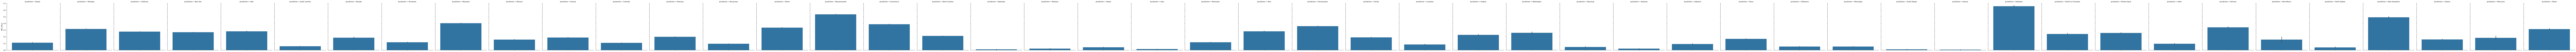

In [157]:
sns.catplot(y='MET_RELA', kind="bar",col="Jurisdiction", data=test)


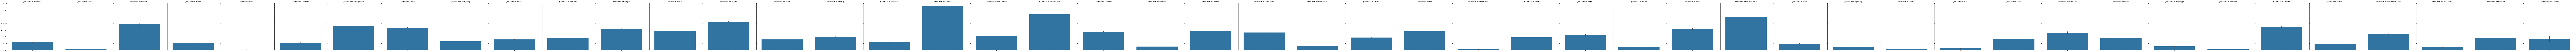

In [159]:
test = teds_imp_laws.copy()
test.loc[:,'MET_RELA'] = test.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=5)
sns.catplot(y='MET_RELA', kind="bar",col="Jurisdiction", data=test)


In [168]:
## Calculate Number of Relapses Per State
teds_imp_laws.assign(
    alc_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=2),
    hrn_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=5),
    met_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=10)
).groupby(['Jurisdiction']).sum().loc[:,['alc_relapse','hrn_relapse', 'met_relapse']]

,alc_relapse,hrn_relapse,met_relapse
Jurisdiction,,,
Alabama,1476,602,1290
Alaska,4233,746,632
Arizona,7008,5142,6421
Arkansas,2073,176,2336
California,10953,19180,26041
Colorado,33818,6211,9727
Connecticut,18781,21866,52
Delaware,735,3194,19
District of Columbia,1410,1058,25
